In [5]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, roc_auc_score, average_precision_score,
    matthews_corrcoef, hamming_loss, multilabel_confusion_matrix
)

# --- Parameters ---
image_dir = "/Users/anatatar/Desktop/Licenta/deepheart/ai_models/data/ecg_images_final"
csv_path = "/Users/anatatar/Desktop/Licenta/deepheart/ai_models/data/labeled_ecg_images.csv"
target_classes = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
image_size = (224, 224)
random_state = 42


In [ ]:
df = pd.read_csv(csv_path)

def find_image_path(filename):
    for folder in os.listdir(image_dir):
        path = os.path.join(image_dir, folder, filename)
        if os.path.exists(path):
            return path
    return None

df['image_path'] = df['filename'].apply(find_image_path)
df = df[df['image_path'].notnull()]
print(f"✅ Total usable samples: {len(df)}")

train_df, test_df = train_test_split(df, test_size=0.15, random_state=random_state)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=random_state)

def load_multilabel_images(df_subset):
    X, y = [], []
    for _, row in df_subset.iterrows():
        img = load_img(row['image_path'], color_mode='rgb', target_size=image_size)
        img_array = img_to_array(img) / 255.0
        label_vector = row[target_classes].values.astype(np.float32)
        X.append(img_array)
        y.append(label_vector)
    return np.array(X), np.array(y)

X_train, y_train = load_multilabel_images(train_df)
X_val, y_val = load_multilabel_images(val_df)
X_test, y_test = load_multilabel_images(test_df)


✅ Total usable samples: 21799


In [3]:
inputs = Input(shape=(224, 224, 3))
base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.4)(x)
output = Dense(len(target_classes), activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=output)

# Freeze early layers
for layer in base_model.layers[:-100]:
    layer.trainable = False

from tensorflow.keras.metrics import AUC, Precision, Recall

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        AUC(curve='ROC', multi_label=True, name='auc'),
        Precision(name='precision'),
        Recall(name='recall'),
        'accuracy'
    ]
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=8,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/25
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 1343s 679ms/step - accuracy: 0.4975 - auc: 0.7413 - loss: 0.4766 - precision: 0.6031 - recall: 0.3869 - val_accuracy: 0.6065 - val_auc: 0.8477 - val_loss: 0.3842 - val_precision: 0.7523 - val_recall: 0.4657
Epoch 2/25
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 1352s 686ms/step - accuracy: 0.5925 - auc: 0.8334 - loss: 0.3986 - precision: 0.7058 - recall: 0.5338 - val_accuracy: 0.6209 - val_auc: 0.8722 - val_loss: 0.3530 - val_precision: 0.7293 - val_recall: 0.6305
Epoch 3/25
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 1372s 697ms/step - accuracy: 0.6245 - auc: 0.8603 - loss: 0.3640 - precision: 0.7366 - recall: 0.5895 - val_accuracy: 0.6306 - val_auc: 0.8830 - val_loss: 0.3419 - val_precision: 0.7352 - val_recall: 0.6394
Epoch 4/25
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 1400s 711ms/step - accuracy: 0.6383 - auc: 0.8747 - loss: 0.3456 - precision: 0.7547 - recall: 0.6144 - val_accuracy: 0.6356 - val_auc: 0.8857 - val_loss: 0.3358 - val_precision: 0.7777 - val_recall: 0.6038
Epoc

In [ ]:
inputs = Input(shape=(224, 224, 3))
base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.4)(x)
output = Dense(len(target_classes), activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=output)

# Freeze early layers
for layer in base_model.layers[:-100]:
    layer.trainable = False

from tensorflow.keras.metrics import AUC, Precision, Recall

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        AUC(curve='ROC', multi_label=True, name='auc'),
        Precision(name='precision'),
        Recall(name='recall'),
        'accuracy'
    ]
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint(
    filepath='best_resnet50_ecg.h5',  # or .keras for newer format
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=8,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)



In [10]:
model.save('resnet_ecg_model.keras')

In [9]:
model.save('resnet/resnet_ecg_model.h5')# or use .h5 if preferred


In [23]:
# Evaluate ResNet model
results = model.evaluate(X_test, y_test, verbose=1)
print("\nTest results:")
print(f"Loss: {results[0]:.4f} | AUC: {results[1]:.4f} | Precision: {results[2]:.4f} | Recall: {results[3]:.4f} | Accuracy: {results[4]:.4f}")

y_pred_probs = model.predict(X_test)
y_pred_bin = (y_pred_probs > 0.5).astype(int)

os.makedirs("resnet", exist_ok=True)
np.save("resnet/y_test.npy", y_test)
np.save("resnet/y_pred_bin.npy", y_pred_bin)
np.save("resnet/y_pred_probs.npy", y_pred_probs)

report = classification_report(y_test, y_pred_bin, target_names=target_classes, zero_division=0)
print(report)

with open("resnet/classification_report_resnet.txt", "w") as f:
    f.write(report)

with open("resnet/all_metrics_resnet.txt", "w") as f:
    f.write("Classification Report:\n" + report + "\n")
    binary_acc = (y_test == y_pred_bin).mean()
    f.write(f"Binary accuracy: {binary_acc:.4f}\n")

    try:
        f.write(f"AUROC macro: {roc_auc_score(y_test, y_pred_probs, average='macro'):.4f}\n")
        f.write(f"AUROC micro: {roc_auc_score(y_test, y_pred_probs, average='micro'):.4f}\n")
    except:
        pass
    try:
        f.write(f"AUPRC macro: {average_precision_score(y_test, y_pred_probs, average='macro'):.4f}\n")
        f.write(f"AUPRC micro: {average_precision_score(y_test, y_pred_probs, average='micro'):.4f}\n")
    except:
        pass

    f.write(f"Hamming Loss: {hamming_loss(y_test, y_pred_bin):.4f}\n")
    f.write(f"Subset Accuracy: {np.all(y_test == y_pred_bin, axis=1).mean():.4f}\n")
    f.write(f"MCC: {matthews_corrcoef(y_test.flatten(), y_pred_bin.flatten()):.4f}\n")

# Save confusion matrices
cm = multilabel_confusion_matrix(y_test, y_pred_bin)
for i, name in enumerate(target_classes):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm[i], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred Neg', 'Pred Pos'],
                yticklabels=['Actual Neg', 'Actual Pos'])
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.savefig(f"resnet/confusion_matrix_{name}.png")
    plt.close()


103/103 ━━━━━━━━━━━━━━━━━━━━ 103s 999ms/step - accuracy: 0.6432 - auc: 0.8877 - loss: 0.3338 - precision: 0.7739 - recall: 0.6452

Test results:
Loss: 0.3368 | AUC: 0.8861 | Precision: 0.7615 | Recall: 0.6449 | Accuracy: 0.6370
103/103 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step
              precision    recall  f1-score   support

        NORM       0.77      0.89      0.83      1442
          MI       0.67      0.47      0.55       776
        STTC       0.79      0.52      0.63       792
          CD       0.81      0.60      0.69       778
         HYP       0.69      0.44      0.54       380

   micro avg       0.76      0.64      0.70      4168
   macro avg       0.75      0.58      0.65      4168
weighted avg       0.76      0.64      0.69      4168
 samples avg       0.70      0.67      0.67      4168



In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

# Load saved predictions and true labels
y_test = np.load("resnet/y_test.npy")
y_pred_bin = np.load("resnet/y_pred_bin.npy")

# Define your class names (replace with your actual classes if needed)
target_classes = ['NORM', 'MI', 'STTC', 'CD', 'HYP']

# Compute confusion matrices
cm = multilabel_confusion_matrix(y_test, y_pred_bin)

# Generate confusion matrices with larger font
for i, name in enumerate(target_classes):
    plt.figure(figsize=(6, 5))
    sns.set(font_scale=1.8)  # Increase font size globally for seaborn
    sns.heatmap(cm[i], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred Neg', 'Pred Pos'],
                yticklabels=['Actual Neg', 'Actual Pos'],
                annot_kws={"size": 20})  # Increase size of annotation numbers
    plt.title(f"Confusion Matrix - {name}", fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    plt.savefig(f"resnet/confusion_matrix_{name}_largefont.png")
    plt.close()

In [3]:
# Index of the class you care about (e.g., HYP)
hyp_index = target_classes.index("HYP")

# Index of the sample
sample_index = 0  # or any other index

# Check correctness
is_correct = y_test[sample_index, hyp_index] == y_pred_bin[sample_index, hyp_index]

print(f"Sample {sample_index} prediction for HYP: {'✅ Correct' if is_correct else '❌ Incorrect'}")


Sample 0 prediction for HYP: ✅ Correct


In [22]:
cm = multilabel_confusion_matrix(y_test, y_pred_bin)
np.save("resnet/confusion_matrices.npy", cm)
with open("resnet/confusion_matrices.txt", "w") as f:
    for i, cls in enumerate(target_classes):
        f.write(f"{cls}:\n{cm[i]}\n")


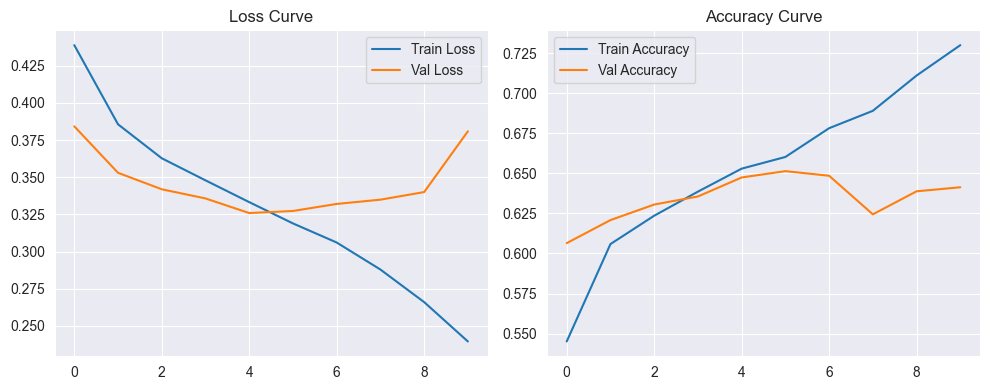

In [14]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.tight_layout()
plt.savefig("resnet/training_curves.png")
plt.show()


In [15]:
def generate_grad_cam(model, image_array, class_index, output_path, last_conv_layer_name="conv5_block3_out"):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        inputs = tf.cast(np.expand_dims(image_array, axis=0), tf.float32)
        conv_outputs, predictions = grad_model(inputs)
        loss = predictions[:, class_index]
    grads = tape.gradient(loss, conv_outputs)[0]  # Shape: [H, W, C]
    conv_outputs = conv_outputs[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))  # Now valid
    cam = np.zeros(conv_outputs.shape[0:2], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * conv_outputs[:, :, i]
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, image_size)
    cam -= cam.min()
    cam /= cam.max()
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    img = np.uint8(255 * image_array)
    overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    cv2.imwrite(output_path, overlay)
    print(f"✅ Grad-CAM saved to {output_path}")


In [18]:
for i, class_name in enumerate(target_classes):
    generate_grad_cam(
        model,
        X_test[0],
        class_index=i,
        output_path=f"resnet/gradcam_{class_name}_sample0.png",
        last_conv_layer_name="conv5_block3_out"
    )


/Users/anatatar/Desktop/Licenta/ai_models/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


✅ Grad-CAM saved to resnet/gradcam_NORM_sample0.png
✅ Grad-CAM saved to resnet/gradcam_MI_sample0.png
✅ Grad-CAM saved to resnet/gradcam_STTC_sample0.png
✅ Grad-CAM saved to resnet/gradcam_CD_sample0.png
✅ Grad-CAM saved to resnet/gradcam_HYP_sample0.png
